## All the required model folders and datasets can be found in : https://drive.google.com/drive/folders/10I830XoPm9ZVwOehBqFPuW4hdTpJPREp?usp=sharing!

# ***Data Preprocessing***

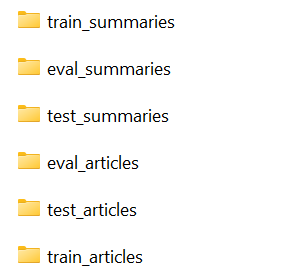

Arrange the annual reports and golden summaries in following structure

In [ ]:
import glob
import os
import re
import pandas as pd
import rouge
from tqdm import tqdm
import regex
from nltk import sent_tokenize, word_tokenize
from typing import Tuple
import nltk
from rouge_score import rouge_scorer


# nltk.download('punkt')


# Download the spaCy English model
#python -m spacy download en_core_web_sm

class Dataset:
    def __init__(self, train_dir, test_dir, val_dir, train_dir_gold, test_dir_gold, val_dir_gold):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.val_dir = val_dir
        self.train_dir_gold = train_dir_gold
        self.test_dir_gold = test_dir_gold
        self.val_dir_gold = val_dir_gold


    @staticmethod
    def tokenized_sent_to_str(tokenized_sent) -> str:
        # remove redundant spaces around sentence delimiters
        for p in ".,?!:;":
            tokenized_sent = tokenized_sent.replace(f" {p}", f"{p}")
        return tokenized_sent

    @staticmethod
    def merge_characters(doc: str):
        """
            Try to merge split characters into words and split sentences by spaces \
            where characters are separated with spaces and words with tabs
        :param doc:
        :return:
        """
        # Rule-based merging
        doc_merged = ""
        doc_split = doc.split("\n")
        max_lines = len(doc_split)
        # Line-level operation is safer and more flexible
        # as in some reports only a few lines require character merging
        for i, line in enumerate(doc_split):
            line_new = str(line)
            # If there is a `\ \t \ ` assume tabs are spaces and delete spaces
            if regex.findall(pattern=r"(?<=\w)\ \t\ ", string=line):
                pattern = regex.compile(r"\ ")
                line_new = pattern.sub("", line)
            if i != max_lines - 1:  # control final end-line
                line_new += "\n"
            doc_merged += line_new
        # Swap tabs for single spaces
        doc_merged = doc_merged.replace("\t", " ")
        return doc_merged

    @staticmethod
    def clean(doc: str):
        # Remove upper-cased lines
        doc = "\n".join([l for l in doc.split("\n") if not l.isupper()]).strip()
        # Perform character-level merging when tabs are used as spaces
        doc = "\n".join([Dataset.merge_characters(l) for l in doc.split("\n")])
        # Make document compact
        doc = doc.replace("\n", " ")
        # remove duplicated spaces
        doc = " ".join(doc.split())
        # reconnect words split by end-of-line hyphenation with lookbehind
        doc = regex.sub(r"(?<=[a-z])-\s", "", doc)
        # remove emails, urls, hours, UK phones, dates
        doc = doc.replace(
            "WWW.", "www."
        )  # ensure url starts lowercase to be caught by regex below
        reg_to_drop = r"""(?x)
            (?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])
            | (https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})
            | ^([0-1]?[0-9]|2[0-3])(:[0-5][0-9])+
            | ^(((\+44\s?\d{4}|\(?0\d{4}\)?)\s?\d{3}\s?\d{3})|((\+44\s?\d{3}|\(?0\d{3}\)?)\s?\d{3}\s?\d{4})|((\+44\s?\d{2}|\(?0\d{2}\)?)\s?\d{4}\s?\d{4}))(\s?\#(\d{4}|\d{3}))?$
            | ^(0?[1-9]|[12][0-9]|3[01])[\/\-](0?[1-9]|1[012])[\/\-]\d{4}$
        """
        pattern = regex.compile(reg_to_drop, regex.UNICODE)
        doc = pattern.sub("", doc)
        # Remove non-alphanumeric and non-special financial characters
        reg_to_drop = r"""(?x) # flag to allow comments and multi-line regex
                [^\w_ |        # alpha-numeric
                \p{Sc} |       # currencies
                \%\&\"\\'\’\(\)\.\,\?\!\-\;\\\/ ]  # preserve apostrophe `’`
            """
        pattern = regex.compile(reg_to_drop, regex.UNICODE)
        doc = pattern.sub("", doc)
        doc = doc.replace("’", "'")  # replace special unicode apostrophe with normal one
        # Deal with unmerged apostrophes
        apostrophes = r"\s*\'s"
        pattern = regex.compile(apostrophes, regex.UNICODE)
        doc = pattern.sub("'s", doc)
        # remove duplicated spaces after dropping special symbols
        doc = " ".join(doc.split())
        # remove redundant spaces around sentence delimiters
        for p in ".,?!:;":
            doc = doc.replace(f" {p}", f"{p}")
        # normalise accents and umlauts
        # doc = unidecode(doc)  # unfortunately normalizes currencies as well
        return doc

    class Tokenize:
        def __init__(self, doc):
            self.sentences = sent_tokenize(doc)


        def lowercase_sentences(self):
            for i, s in enumerate(self.sentences):
                self.sentences[i] = s.lower()

        def __str__(self):
            d = ""
            for i, sentence in enumerate(self.sentences):
                d += Dataset.tokenized_sent_to_str(sentence) + " "
            d = d.strip()
            return d

    def preprocess_text(self, file_path):
        # Open the file for reading
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        cleaned_lines = []
        for line in lines:
            # Check if "fax" or "tel" is present in the line
            if 'fax' in line.lower() or 'tel' in line.lower():
                continue  # Skip the line if "fax" or "tel" is present

            # Remove extra white spaces, except in numbers or dates
            cleaned_line = re.sub(r'\s+', ' ', line.strip())

            # Remove leading/trailing spaces from each line
            cleaned_line = cleaned_line.strip()

            # Ensure spaces around hyphens to retain formatting in numbers or dates
            cleaned_line = re.sub(r'(\d) - (\d)', r'\1-\2', cleaned_line)

            # Remove standalone dashes but retain dashes in words (like non-financial)
            cleaned_line = re.sub(r'\b-\b', '', cleaned_line)

            # Retain specific formatting in numbers and dates
            cleaned_line = re.sub(r'(\d{2}/\d{2}/\d{2})', r'\1 ', cleaned_line)
            cleaned_line = re.sub(r'(\d{2}/\d{2}/\d{2}) to (\d{2}/\d{2}/\d{2})', r'\1 to \2', cleaned_line)

            # Remove currency symbols if they are standalone
            cleaned_line = re.sub(r'(?<!\w)[£$€](?!\w)', '', cleaned_line)

            # Remove repeating special characters if they are at the start or continuously
            cleaned_line = re.sub(r'(\W)\1{0,}', r'\1', cleaned_line)

            # Remove trailing period at the end of sentences
            cleaned_line = re.sub(r'(\w+)\.\s$', r'\1', cleaned_line)

            # Remove empty lines and lines with only whitespace characters
            if cleaned_line.strip():
                # Lowercase the line and add to cleaned lines
                cleaned_lines.append(cleaned_line)

        return '\n'.join(cleaned_lines)


    def preprocess(self, doc: str, output_path: str, is_lower: bool = True) -> Tuple[str, Tokenize]:
        # Clean the data
        doc = Dataset.clean(doc)
        # Split content document into sentences
        cleaned_doc = self.Tokenize(doc)

        doc_tokenized=""
        for s in cleaned_doc.sentences:
            num_numbers=0
            num_words=0
            w=word_tokenize(s)
            for t in w:
                if not any(char.isdigit() for char in t):
                    num_words += 1
                # Check if the token is a number
                elif t.replace('.', '').isdigit():
                    num_numbers += 1
            # Check if the number of numbers is greater than the number of words
            if len(w) > 3 and num_numbers <= num_words:
                doc_tokenized+=s.lower()+" "

        file_name = os.path.basename(output_path)
        # file_name_without_extension, extension = os.path.splitext(file_name)
        output_file_path = os.path.join(os.path.dirname(output_path)+"/Cleaned/", file_name)

        with open(output_file_path, 'w', encoding='utf-8') as file:
            file.write(str(doc_tokenized))

        return str(doc_tokenized)


    def calculate_rouge_score(self, sentence, golden_summaries):
        scorer = rouge_scorer.RougeScorer([ 'rouge2'], use_stemmer=True)
        scores = [scorer.score(sentence, summary) for summary in golden_summaries]
        max_rouge_score = max(scores, key=lambda x: x['rouge2'].fmeasure)
        return max_rouge_score['rouge2'].fmeasure

    def parse_train(self, data_dir, gold_dir):
        dataset = {'Sentence': [], 'Score': []}
        os.chdir(data_dir)
        for file_name in tqdm(glob.glob("*.txt")):
            key = file_name
            file_path=os.path.join(data_dir, key)
            # Apply text preprocessing
            cleaned_text = self.preprocess_text(file_path)
            # Apply text preprocessing
            cleaned_text = self.preprocess(cleaned_text,file_path)
            golden_summaries=[]
            name, extension = file_name.split(".")
            for i in [1, 2, 3, 4, 5, 6, 7]:
                try:
                    summary = open(os.path.join(gold_dir, name + "_" + str(i) + "." + extension),encoding="utf-8").read()
                    golden_summaries.append(summary)
                except Exception as e:
                    continue

            # Tokenize sentences from cleaned text
            cleaned_tokenizer = self.Tokenize(cleaned_text)

            for sentence in cleaned_tokenizer.sentences:
                score = self.calculate_rouge_score(sentence, golden_summaries)
                dataset['Sentence'].append(sentence)
                dataset['Score'].append(score)
            df = pd.DataFrame(dataset)

            # Save the DataFrame to a CSV file
            os.chdir(data_dir+"/CSV/")
            df.to_csv('training.csv', index=False)

    def parse_valid(self, data_dir, gold_dir):
        dataset = {'Sentence': [], 'Score': []}
        os.chdir(data_dir)
        for file_name in tqdm(glob.glob("*.txt")):
            key = file_name
            file_path=os.path.join(data_dir, key)
            # Apply text preprocessing
            cleaned_text = self.preprocess_text(file_path)
            # Apply text preprocessing
            cleaned_text = self.preprocess(cleaned_text,file_path)
            golden_summaries=[]
            name, extension = file_name.split(".")
            for i in [1, 2, 3, 4, 5, 6, 7]:
                try:
                    summary = open(os.path.join(gold_dir, name + "_" + str(i) + "." + extension),encoding="utf-8").read()
                    golden_summaries.append(summary)
                except Exception as e:
                    continue
            # Tokenize sentences from cleaned text
            cleaned_tokenizer = self.Tokenize(cleaned_text)

            for sentence in cleaned_tokenizer.sentences:
                score = self.calculate_rouge_score(sentence, golden_summaries)
                dataset['Sentence'].append(sentence)
                dataset['Score'].append(score)
            df = pd.DataFrame(dataset)

            # Save the DataFrame to a CSV file
            os.chdir(data_dir+"/CSV/")
            df.to_csv('validation.csv', index=False)


    def parse_test(self, data_dir, gold_dir):
        dataset = {'Sentence': [],"Filename":[],"sentence_id":[]}
        os.chdir(data_dir)
        for file_name in tqdm(glob.glob("*.txt")):
            key = file_name
            file_path=os.path.join(data_dir, key)
            cleaned_text = self.preprocess_text(file_path)
            cleaned_text = self.preprocess(cleaned_text,file_path)
            name, extension = file_name.split(".")
            cleaned_tokenizer = self.Tokenize(cleaned_text)
            for i,sentence in enumerate(cleaned_tokenizer.sentences):
                dataset['Sentence'].append(sentence)
                dataset['FileName'].append(name)
                dataset['sentence_id'].append(i+1)

            df = pd.DataFrame(dataset)

            # Save the DataFrame to a CSV file
            os.chdir(data_dir+"/CSV/")
            df.to_csv('testing.csv', index=False)


    def parse_train_data(self):
        print("Parsing Training Data")
        self.parse_train(self.train_dir, self.train_dir_gold)

    def parse_validation_data(self):
        print("Parsing Validation Data")
        self.parse_valid(self.val_dir, self.val_dir_gold)

    def parse_test_data(self):
        print("Parsing Test Data")
        self.parse_test(self.test_dir, self.test_dir_gold)


# Set the base path for your dataset
base_path = 'C:/Users/mahen/Downloads/fns2020_dataset-Final/Data/'  # Update with your CSV file path

# Create an instance of the Dataset class
data = Dataset(
    train_dir=base_path + "train_articles/",
    test_dir=base_path + "test_articles/", #  incldue same files as in eval_articles
    val_dir=base_path + "eval_articles/",
    train_dir_gold=base_path + "train_summaries/",
    test_dir_gold=base_path + "test_summaries/",  # incldue same files as in eval_summaries
    val_dir_gold=base_path + "eval_summaries/"
)

# Parse the datasets
data.parse_train_data()
data.parse_validation_data()
data.parse_test_data()




In [ ]:
# Function to count tokens in a sentence
def count_tokens(sentence):
    tokens = word_tokenize(sentence)
    return len(tokens)


# Load the CSV file
csv_file_path = "/home/student/Downloads/fns2020_dataset/Data/train_articles/CSV/training.csv"  # Update with your CSV file path
data = pd.read_csv(csv_file_path)

# Remove duplicates
data.drop_duplicates(subset='Sentence', inplace=True)
data['NumTokens'] = data['Sentence'].apply(count_tokens)

# Function to check condition for removing sentences
def should_remove(sentence):
    num_white_spaces = sum(1 for char in sentence if char.isspace())
    num_non_white_spaces = len(sentence) - num_white_spaces
    return num_white_spaces > (num_non_white_spaces / 3)

# Filter out sentences based on the condition
data_filtered = data[~data['Sentence'].apply(should_remove)]
# Filter out sentences with more than 5 tokens
data_filtered = data_filtered[data_filtered['NumTokens'] > 5]

# Save the filtered DataFrame to a new CSV file
output_csv_file_path = "/home/student/Downloads/fns2020_dataset/Data/train_articles/CSV/training_filtered.csv"  # Update with your desired output CSV file path
data_filtered.to_csv(output_csv_file_path, index=False)

print("Filtered CSV file has been saved to:", output_csv_file_path)



# Load the CSV file
csv_file_path = "/home/student/Downloads/fns2020_dataset/Data/train_articles/CSV/validation.csv"  # Update with your CSV file path
data = pd.read_csv(csv_file_path)

# Remove duplicates
data.drop_duplicates(subset='Sentence', inplace=True)
data['NumTokens'] = data['Sentence'].apply(count_tokens)

# Function to check condition for removing sentences
def should_remove(sentence):
    num_white_spaces = sum(1 for char in sentence if char.isspace())
    num_non_white_spaces = len(sentence) - num_white_spaces
    return num_white_spaces > (num_non_white_spaces / 3)

# Filter out sentences based on the condition
data_filtered = data[~data['Sentence'].apply(should_remove)]
# Filter out sentences with more than 5 tokens
data_filtered = data_filtered[data_filtered['NumTokens'] > 5]

# Save the filtered DataFrame to a new CSV file
output_csv_file_path = "/home/student/Downloads/fns2020_dataset/Data/train_articles/CSV/validation_filtered.csv"  # Update with your desired output CSV file path
data_filtered.to_csv(output_csv_file_path, index=False)

print("Filtered CSV file has been saved to:", output_csv_file_path)



# Load the CSV file
csv_file_path = "/home/student/Downloads/fns2020_dataset/Data/train_articles/CSV/testing.csv"  # Update with your CSV file path
data = pd.read_csv(csv_file_path)

# Remove duplicates
data.drop_duplicates(subset='Sentence', inplace=True)
data['NumTokens'] = data['Sentence'].apply(count_tokens)

# Function to check condition for removing sentences
def should_remove(sentence):
    num_white_spaces = sum(1 for char in sentence if char.isspace())
    num_non_white_spaces = len(sentence) - num_white_spaces
    return num_white_spaces > (num_non_white_spaces / 3)

# Filter out sentences based on the condition
data_filtered = data[~data['Sentence'].apply(should_remove)]
# Filter out sentences with more than 5 tokens
data_filtered = data_filtered[data_filtered['NumTokens'] > 5]

# Save the filtered DataFrame to a new CSV file
output_csv_file_path = "/home/student/Downloads/fns2020_dataset/Data/train_articles/CSV/testing_filtered.csv"  # Update with your desired output CSV file path
data_filtered.to_csv(output_csv_file_path, index=False)

print("Filtered CSV file has been saved to:", output_csv_file_path)

# ***Fine-tuning***

In [ ]:
!pip install accelerate -U
!pip install rouge_score
!pip install bert-score

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import BertTokenizer, BertConfig, BertModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
from nltk import word_tokenize
from rouge_score import rouge_scorer
import os
import warnings
warnings.filterwarnings("ignore")
from bert_score import score
import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
'''we are performing 2-stage finetuning as the size of data is large'''
# Load preprocessed data from CSV
train_data = pd.read_csv('/content/drive/MyDrive/NLP-Text Summarization/train_filtered.csv') # this contains the annotated data for first 1500 reports, this is for 1st stage of fine-tuning, comment this line when performing for 2nd stage of finetuning
train_data = pd.read_csv('/content/drive/MyDrive/NLP-Text Summarization/training_2_filtered.csv') # this contains the annotated data for last 1500 reports, this is for 2nd stage of fine-tuning, comment this line when performing for 1st stage of finetuning
valid_data = pd.read_csv('/content/drive/MyDrive/NLP-Text Summarization/valid_filtered.csv') # Update with your CSV file path
test_data = pd.read_csv('/content/drive/MyDrive/NLP-Text Summarization/testing_filtered.csv') # Update with your CSV file path

# Split data into features and labels
X_train = train_data['Sentence']
y_train = train_data['Score']

X_val = valid_data['Sentence']
y_val = valid_data['Score']

X_test = test_data['Sentence']

In [ ]:
valid_data

,Sentence,Score,NumTokens
0,certain statements in this swallowfield plc an...,0.006421,15
1,"forwardlooking statements may sometimes, but n...",0.000770,32
2,these forwardlooking statements are subject to...,0.003704,48
3,such statements are made only as at the date o...,0.003125,34
4,swallowfield plc is a market leader in the dev...,0.022727,21
...,...,...,...
576034,we also own or have the rights to copyrights t...,0.004098,17
576035,"solely for convenience, the trademarks, servic...",0.009862,64
576036,"this annual report may include trademarks, ser...",0.003546,16
576037,the use or display of other parties' trademark...,0.003396,47


In [ ]:
test_data

,Sentence,FileName,sentence_id,NumTokens
0,certain statements in this swallowfield plc an...,32020.txt,1,15
1,"forwardlooking statements may sometimes, but n...",32020.txt,2,32
2,these forwardlooking statements are subject to...,32020.txt,3,48
3,such statements are made only as at the date o...,32020.txt,4,34
4,swallowfield plc is a market leader in the dev...,32020.txt,5,21
...,...,...,...,...
576034,we also own or have the rights to copyrights t...,32854.txt,3435,17
576035,"solely for convenience, the trademarks, servic...",32854.txt,3436,64
576036,"this annual report may include trademarks, ser...",32854.txt,3437,16
576037,the use or display of other parties' trademark...,32854.txt,3438,47


In [ ]:
# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Tokenize input sentences
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True,max_length=128)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True,max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True,max_length=128)

'''As the tokenization for train_encodings and val_encodings is taking more time we save them in HDF5 file and directly reading them everytime during training'''

In [ ]:
# Convert BatchEncoding objects to dictionaries
train_encodings_dict = train_encodings.data
val_encodings_dict = val_encodings.data
test_encodings_dict = test_encodings.data

In [ ]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings_dict['input_ids']),
    torch.tensor(train_encodings_dict['attention_mask']),
    torch.tensor(train_data['Score'].tolist())
)

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings_dict['input_ids']),
    torch.tensor(val_encodings_dict['attention_mask']),
    torch.tensor(valid_data['Score'].tolist())
)


test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings_dict['input_ids']),
    torch.tensor(test_encodings_dict['attention_mask'])
)

In [ ]:
# import h5py

# # Save train encodings to an HDF5 file
# train_encodings_path_hdf5 = '/content/drive/MyDrive/NLP-Text Summarization/train_encodings.hdf5'
# with h5py.File(train_encodings_path_hdf5, 'w') as hf:
#     hf.create_dataset('input_ids', data=train_encodings_dict['input_ids'])
#     hf.create_dataset('attention_mask', data=train_encodings_dict['attention_mask'])
#     hf.create_dataset('scores', data=train_data['Score'].tolist())

# # Save validation encodings to an HDF5 file
# val_encodings_path_hdf5 = '/content/drive/MyDrive/NLP-Text Summarization/val_encodings.hdf5'
# with h5py.File(val_encodings_path_hdf5, 'w') as hf:
#     hf.create_dataset('input_ids', data=val_encodings_dict['input_ids'])
#     hf.create_dataset('attention_mask', data=val_encodings_dict['attention_mask'])
#     hf.create_dataset('scores', data=valid_data['Score'].tolist())

# # Save validation encodings to an HDF5 file
# test_encodings_path_hdf5 = '/content/drive/MyDrive/NLP-Text Summarization/test_encodings.hdf5'
# with h5py.File(test_encodings_path_hdf5, 'w') as hf:
#     hf.create_dataset('input_ids', data=test_encodings_dict['input_ids'])
#     hf.create_dataset('attention_mask', data=test_encodings_dict['attention_mask'])

In [ ]:
# !cp -r "/content/test_encodings.hdf5" "/content/drive/MyDrive/NLP-Text Summarization/"

In [ ]:
# import h5py

# train_encodings_path_hdf5 = '/content/drive/MyDrive/NLP-Text Summarization/train_encodings_2.hdf5'
# val_encodings_path_hdf5 = '/content/drive/MyDrive/NLP-Text Summarization/val_encodings.hdf5'
# test_encodings_path_hdf5 = '/content/drive/MyDrive/NLP-Text Summarization/test_encodings.hdf5'

# with h5py.File(train_encodings_path_hdf5, 'r') as hf:
#     input_ids_train = hf['input_ids'][:]
#     attention_mask_train = hf['attention_mask'][:]
#     scores_train = hf['scores'][:]

# with h5py.File(val_encodings_path_hdf5, 'r') as hf:
#     input_ids_val = hf['input_ids'][:]
#     attention_mask_val = hf['attention_mask'][:]
#     scores_val = hf['scores'][:]

# with h5py.File(test_encodings_path_hdf5, 'r') as hf:
#     input_ids_test = hf['input_ids'][:]
#     attention_mask_test = hf['attention_mask'][:]


In [ ]:
# Convert tokenized sentences to PyTorch tensors
# train_dataset = torch.utils.data.TensorDataset(
#     torch.tensor(input_ids_train),
#     torch.tensor(attention_mask_train),
#     torch.tensor(scores_train.tolist())
# )

# val_dataset = torch.utils.data.TensorDataset(
#     torch.tensor(input_ids_val),
#     torch.tensor(attention_mask_val),
#     torch.tensor(scores_val.tolist())
# )

# test_dataset = torch.utils.data.TensorDataset(
#     torch.tensor(input_ids_test),
#     torch.tensor(attention_mask_test)
# )


In [ ]:
# Load BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased',num_labels=1) # comment this when performing 2nd stage of  finetuning

In [ ]:
# Load BERT model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP-Text Summarization/bert_regression_model/',num_labels=1) # comment this when performining 1st stage of finetuning

In [ ]:
# Define a custom training step function
def compute_metrics(p):
    predictions = torch.tensor(p.predictions.squeeze(), dtype=torch.float).clone().detach()  # Remove unnecessary dimensions
    labels = torch.tensor(p.label_ids, dtype=torch.float).clone().detach()  # Convert labels to float
    mse = ((predictions - labels) ** 2).mean().item()
    return {"mse": mse}

# Define custom data collator
class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # Unpack features
        input_ids = torch.stack([torch.tensor(feature[0].clone().detach()) for feature in features])
        attention_mask = torch.stack([torch.tensor(feature[1].clone().detach()) for feature in features])
        labels = torch.tensor([feature[2] for feature in features], dtype=torch.float)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Instantiate custom data collator
data_collator = CustomDataCollator(tokenizer)

In [ ]:


# Instantiate Trainer with custom data collator
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,  # Use custom data collator
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Use custom metrics function
)

In [ ]:

# Define training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    learning_rate=5e-5,
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='mse',
    greater_is_better=False,
    fp16=True,
    weight_decay=0.01,
    gradient_accumulation_steps = 2 ,
    warmup_steps=200,                 # Decrease warmup steps
)

In [ ]:
# Train the model
trainer.train()


<ipython-input-9-c695594f6adb>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.stack([torch.tensor(feature[0].clone().detach()) for feature in features])
<ipython-input-9-c695594f6adb>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.stack([torch.tensor(feature[1].clone().detach()) for feature in features])


Epoch,Training Loss,Validation Loss,Mse
1,0.000600,0.000401,0.000401


TrainOutput(global_step=6062, training_loss=0.0005705994924119265, metrics={'train_runtime': 9783.9352, 'train_samples_per_second': 158.602, 'train_steps_per_second': 0.62, 'total_flos': 1.0207005747345024e+17, 'train_loss': 0.0005705994924119265, 'epoch': 1.0})

In [ ]:

# # # Evaluate the model
# eval_result = trainer.evaluate()
# print(f"Validation MSE: {eval_result['eval_mse']}")



In [ ]:
# Save the model
trainer.save_model('./bert_regression_model_2') # change folder path to "./bert_regression_model" for 1st stage finetuning

In [ ]:
# !cp -r "/content/bert_regression_model_2" "/content/drive/MyDrive/NLP-Text Summarization/" # Update with your folder path

In [ ]:
# !cp -r "/content/drive/MyDrive/NLP-Text Summarization/bert_regression_model/" "/content/bert_regression_model" # Update with your folder path

# ***Testing***

In [ ]:
!pip install accelerate -U
!pip install rouge_score
!pip install bert-score

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import BertTokenizer, BertConfig, BertModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
from nltk import word_tokenize
from rouge_score import rouge_scorer
import os
import warnings
warnings.filterwarnings("ignore")
from bert_score import score
import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/NLP-Text Summarization/testing_filtered.csv') # Update with your CSV file path

X_test = test_data['Sentence']

In [ ]:
# Tokenize input sentences
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True,max_length=128)

In [ ]:
# Convert BatchEncoding objects to dictionaries
test_encodings_dict = test_encodings.data

In [ ]:
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings_dict['input_ids']),
    torch.tensor(test_encodings_dict['attention_mask'])
)

In [ ]:
# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Load BERT model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP-Text Summarization/bert_regression_model_2/',num_labels=1) # Update with your folder path of saved modle after 2nd stage of finetuning

In [ ]:
# Define custom data collator
class CustomTestDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # Unpack features
        input_ids = torch.stack([torch.tensor(feature[0].clone().detach()) for feature in features])
        attention_mask = torch.stack([torch.tensor(feature[1].clone().detach()) for feature in features])

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

# Instantiate custom data collator
test_data_collator = CustomTestDataCollator(tokenizer)

In [ ]:
# Create a Trainer instance with the saved model and test dataset
trainer = Trainer(
    model=model,
    data_collator=test_data_collator,
    args=training_args,
    eval_dataset=test_dataset,
)

# Evaluate the model on the test set
predictions = trainer.predict(test_dataset)

In [ ]:
for i in range(len(predictions[0])):
  test_data["Score"][i]=predictions[0][i][0]

In [ ]:
test_data.to_csv("/content/drive/MyDrive/NLP-Text Summarization/final_testing.csv")

# ***Post-Processing***

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/NLP-Text Summarization/final_testing.csv',encoding='utf-8') # save the new csv to desired path

In [ ]:
test_data= test_data[['Sentence', 'FileName', 'sentence_id', 'NumTokens', 'Score']]

In [ ]:
test_data

,Sentence,FileName,sentence_id,NumTokens,Score
0,certain statements in this swallowfield plc an...,32020.txt,1,15,0.041290
1,"forwardlooking statements may sometimes, but n...",32020.txt,2,32,0.001208
2,these forwardlooking statements are subject to...,32020.txt,3,48,0.015068
3,such statements are made only as at the date o...,32020.txt,4,34,0.010918
4,swallowfield plc is a market leader in the dev...,32020.txt,5,21,0.025421
...,...,...,...,...,...
576034,we also own or have the rights to copyrights t...,32854.txt,3435,17,0.006050
576035,"solely for convenience, the trademarks, servic...",32854.txt,3436,64,0.021500
576036,"this annual report may include trademarks, ser...",32854.txt,3437,16,0.005379
576037,the use or display of other parties' trademark...,32854.txt,3438,47,0.003660


In [ ]:
test_data_sorted = test_data.sort_values(by=['FileName', 'Score'], ascending=False)

In [ ]:
test_data_sorted

,Sentence,FileName,sentence_id,NumTokens,Score
456164,37 current underprovision of quality dining of...,33155.txt,541,128,0.221802
456002,silverburn benefits from scotland's largest st...,33155.txt,379,121,0.192261
456103,the €7 billion investment has been the catalys...,33155.txt,480,149,0.169800
455625,highlights 01 our business at a glance 02 our ...,33155.txt,2,323,0.153198
455628,21 shopping centres 21 retail parks 15 premium...,33155.txt,5,340,0.135864
...,...,...,...,...,...
527999,clawback provisions apply to amounts for two y...,30777.txt,1273,11,-0.000376
527466,p. larmon and l. chahbazi are nonexecutive dir...,30777.txt,708,9,-0.000422
527338,scope 2 emissions are indirect energy emission...,30777.txt,574,21,-0.000541
527796,cip awards are subject to an absolute tsr target.,30777.txt,1050,10,-0.000731


In [ ]:
files=set(test_data_sorted["FileName"])
output={"FileName":[],"Sentence":[],"sentence_id":[],"Score":[]}
for i in files:
  filtered_df = test_data_sorted[test_data_sorted['FileName'] == i].reset_index(drop=True)
  summary=""
  for j in range(len(filtered_df["Sentence"])):
    if len(word_tokenize(summary))<1000:
      summary+=filtered_df["Sentence"][j]
      output["FileName"].append(i)
      output["Sentence"].append(filtered_df["Sentence"][j])
      output["sentence_id"].append(filtered_df["sentence_id"][j])
      output["Score"].append(filtered_df["Score"][j])

    else:
      break

In [ ]:
output_df = pd.DataFrame(output)

In [ ]:
output_df = output_df.sort_values(by=['FileName', 'sentence_id'], ascending=True)

In [ ]:
output_df.head(10)

,FileName,Sentence,sentence_id,Score
2165,30777.txt,25695 19 march 2018 329 pm proof 7 25695 19 ma...,1,0.203735
2166,30777.txt,throughout this report you will see illustrati...,10,0.134521
2167,30777.txt,a. c. quinn cbe chairman i am pleased to be co...,41,0.115723
2168,30777.txt,below are a few examples of material propertie...,244,0.109497
2169,30777.txt,main body page section a at a glance 56 sectio...,1033,0.106995
2553,30778.txt,key priorities for 2018 are as follows optimis...,7,0.211060
2552,30778.txt,3 overview strategic report corporate governan...,9,0.244385
2557,30778.txt,all nine of our work programme contracts are i...,11,0.129150
2555,30778.txt,john crabtree obe chairman underlying profit b...,25,0.164185
2556,30778.txt,this factor has become a regular feature of ou...,184,0.158447


In [ ]:
summary_csv={"FileName":[],"Summary":[]}
for i in files:
  filtered_df = output_df[output_df['FileName'] == i].reset_index(drop=True)
  summary=""
  for j in filtered_df["Sentence"]:
    summary+=j

  summary_csv["FileName"].append(i)
  summary_csv["Summary"].append(summary)


In [ ]:
final_summaries = pd.DataFrame(summary_csv)
final_summaries

,FileName,Summary
0,32414.txt,accsys technologies plc 2017 cover images 1 ac...
1,32936.txt,highland gold mining limited | annual report a...
2,31224.txt,1 highlights 2 gan at a glance 4 market review...
3,31165.txt,americas net fee income (2017) £7.3m brands al...
4,30779.txt,"1,745 2,094 2,321 2017 2016 2015 111.0 138.6 1..."
...,...,...
356,32408.txt,25474.04 4 august 2017 1012 am proof 7 nakama ...
357,31478.txt,the best place to watch a movie cineworld grou...
358,31617.txt,registered number 09595911 (england and wales)...
359,31474.txt,1 2 4 1 3 5 overview worldclass problem solvin...


In [ ]:
# a=final_summaries[final_summaries['FileName'] == '30777.txt']["Summary"]

In [ ]:
final_summaries.to_csv('/content/drive/MyDrive/NLP-Text Summarization/final_testing_latest.csv')

In [ ]:
import os
import pandas as pd

# Directory where you want to save the text files
output_directory = "C:/Users/mahen/Downloads/rouge2_v1.2.2_runnable/v1.2.2/projects/test-summarization/system" # Update with file path to svae the new summaries as .txt files
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('final_testing_latest.csv') # Update with your final CSV file path
# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    filename = f"{row['filename'][:-4]}_.txt"  # Extracting the filename without the extension
    summary = row['summary']

    # Specify the full path for the text file
    file_path = os.path.join(output_directory, filename)

    # Write the summary to a text file
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(summary)

print("Text files created successfully.")


In [ ]:
'''Computer ROUGE-2 socre using https://github.com/kavgan/ROUGE-2.0, on the saved summaries and thier golden summaries, the metrics are stored in "results.csv" file'''

In [ ]:
import os
import pandas as pd

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('results.csv') # Update with your CSV file path

In [ ]:
df.dropna(subset=['Task Name'], inplace=True)

In [ ]:
df

,ROUGE-Type,Task Name,System Name,Avg_Recall,Avg_Precision,Avg_F-Score,Num Reference Summaries
0,ROUGE-L+StopWordRemoval,33090.0,.TXT,0.58960,0.44357,0.50627,4.0
2,ROUGE-1+StopWordRemoval,33090.0,.TXT,0.64286,0.43251,0.51712,4.0
4,ROUGE-2+StopWordRemoval,33090.0,.TXT,0.50855,0.25242,0.33738,4.0
6,ROUGE-SU4+StopWordRemoval,33090.0,.TXT,0.54332,0.23507,0.32816,4.0
8,ROUGE-L+StopWordRemoval,30817.0,.TXT,0.49907,0.25090,0.33392,3.0
...,...,...,...,...,...,...,...
2886,ROUGE-SU4+StopWordRemoval,31008.0,.TXT,0.29085,0.24452,0.26568,3.0
2888,ROUGE-L+StopWordRemoval,32217.0,.TXT,0.47313,0.25205,0.32889,4.0
2890,ROUGE-1+StopWordRemoval,32217.0,.TXT,0.59869,0.15147,0.24177,4.0
2892,ROUGE-2+StopWordRemoval,32217.0,.TXT,0.36241,0.05786,0.09979,4.0


In [ ]:
r_l=df[df['ROUGE-Type'] == 'ROUGE-L+StopWordRemoval']
r1=df[df['ROUGE-Type'] == 'ROUGE-1+StopWordRemoval']
r2=df[df['ROUGE-Type'] == 'ROUGE-2+StopWordRemoval']
rs=df[df['ROUGE-Type'] == 'ROUGE-SU4+StopWordRemoval']

In [ ]:
print(" Average Recall",r_l["Avg_Recall"].mean(),'\n',"Average Precision",r_l["Avg_Precision"].mean(),'\n',"Average F1-Score",r_l["Avg_F-Score"].mean())

 Average Recall 0.41019257617728533 
 Average Precision 0.3858508033240997 
 Average F1-Score 0.38856614958448754


In [ ]:
print(" Average Recall",r1["Avg_Recall"].mean(),'\n',"Average Precision",r1["Avg_Precision"].mean(),'\n',"Average F1-Score",r1["Avg_F-Score"].mean())

 Average Recall 0.502353351800554 
 Average Precision 0.3849537673130195 
 Average F1-Score 0.4231780609418282


In [ ]:
print(" Average Recall",r2["Avg_Recall"].mean(),'\n',"Average Precision",r2["Avg_Precision"].mean(),'\n',"Average F1-Score",r2["Avg_F-Score"].mean())

 Average Recall 0.30944180055401665 
 Average Precision 0.17398396121883655 
 Average F1-Score 0.21434922437673126


In [ ]:
print(" Average Recall",rs["Avg_Recall"].mean(),'\n',"Average Precision",rs["Avg_Recall"].mean(),'\n',"Average F1-Score",rs["Avg_F-Score"].mean())

 Average Recall 0.3695549584487534 
 Average Precision 0.3695549584487534 
 Average F1-Score 0.23810332409972298


In [ ]:
# !unzip "/content/drive/MyDrive/NLP-Text Summarization/system.zip" -d "/content/drive/MyDrive/NLP-Text Summarization/"

In [ ]:
data_dir='/content/drive/MyDrive/NLP-Text Summarization/system' # Update with your folder path of summaries generated by model
gold_dir='/content/drive/MyDrive/NLP-Text Summarization/reference' # Update with your folder path golden summaries
os.chdir(data_dir)

bs={"precision":[],"recall":[],"fmeasure":[]}

for file_name in tqdm(glob.glob("*.txt")):
    key = file_name
    file_path=os.path.join(data_dir, key)
    gen_summary = open(file_path,encoding="utf-8").read()
    # os.chdir(gold_dir)
    golden_summaries=[]
    name, extension = file_name.split(".")
    # print(name,extension)
    for i in [1, 2, 3, 4, 5, 6, 7]:
        try:
            summary = open(os.path.join(gold_dir, name + str(i) + "." + extension),encoding="utf-8").read()
            P, R, F1 = score([gen_summary], [summary], lang='en', model_type='bert-base-uncased', verbose=False)
            # print(P.item(),R.item(),F1.item())
            bs["precision"].append(P.item())
            bs["recall"].append(R.item())
            bs["fmeasure"].append(F1.item())

        except Exception as e:
            continue


100%|██████████| 361/361 [1:33:21<00:00, 15.52s/it]


In [ ]:
bs

In [ ]:
bert_scores=pd.DataFrame(bs)

In [ ]:
bert_scores

,precision,recall,fmeasure
0,0.519564,0.480450,0.499242
1,0.563550,0.638339,0.598618
2,0.496845,0.478308,0.487400
3,0.654834,0.616444,0.635059
4,0.595017,0.552984,0.573231
...,...,...,...
1238,0.517627,0.481326,0.498817
1239,0.537913,0.502420,0.519561
1240,0.608729,0.798962,0.690992
1241,0.434930,0.478836,0.455828


In [ ]:
bert_scores.to_csv("/content/drive/MyDrive/NLP-Text Summarization/bert_results.csv", index=False) # Update with your CSV file path, you wanted

In [ ]:
print(" Average Recall",bert_scores["recall"].mean(),'\n',"Average Precision",bert_scores["precision"].mean(),'\n',"Average F1-Scoer",bert_scores["fmeasure"].mean())

 Average Recall 0.5840449132750519 
 Average Precision 0.5709493546263402 
 Average F1-Scoer 0.5760622618904252


# ***Optional***

In [ ]:
# test_data.to_csv('/content/drive/MyDrive/NLP-Text Summarization/final_testing.csv')

In [ ]:
# # Sorting the dictionary by values in decreasing order
# sorted_dict = dict(sorted(outputs.items(), key=lambda item: item[1], reverse=True))

In [ ]:
# summary=""
# for i in sorted_dict:
#   if len(word_tokenize(summary))<1000:
#     summary+=i
#   else:
#     break

In [ ]:
# summary

In [ ]:
# def calculate_rouge_score(sentence, golden_summaries):
#     scorer = rouge_scorer.RougeScorer([ 'rouge2'], use_stemmer=True)
#     scores = []
#     bert_scores=[]
#     for summary in golden_summaries:
#       scores.append(scorer.score(sentence, summary))
#       P, R, F1 = score([sentence], [summary], lang='en', model_type='bert-base-uncased', verbose=False)
#       bert_scores.append(F1.item())
#       print(P,R,F1)
#     rouge_scores=[]
#     for i in scores:
#       print(i)
#       rouge_scores.append(i['rouge2'].fmeasure)
#     # max_rouge_score = max(scores, key=lambda x: x['rouge2'].fmeasure)
#     return rouge_scores, bert_scores

In [ ]:
# golden_summaries=[]
# file_name="33027.txt"
# for i in [1, 2, 3, 4, 5, 6, 7]:
#     try:
#         name, extension = file_name.split(".")
#         test_summary = open(os.path.join('/content/drive/MyDrive/NLP-Text Summarization/test_summaries/', name + "_" + str(i) + "." + extension),encoding="utf-8").read()
#         golden_summaries.append(test_summary)

#     except Exception as e:
#         continue

In [ ]:
# rouge_score, bert_score=calculate_rouge_score(summary,golden_summaries)

In [ ]:
# rouge_score

[0.1370967741935484,
 0.0650994575045208,
 0.11909487892020644,
 0.7002341920374707]

In [ ]:
# bert_score

[0.5060145258903503, 0.524713397026062, 0.5919580459594727, 0.6018878221511841]